## 0. Introduction 

The aim of this lab is to get familiar with **Neural Networks**. We will be using some code extracts that were implemented on the week 4 Classification I lab and build a Neural Network. 

1.   This lab is part of Assignment 1 part 2.
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebook.
3. You should sibmit **a single report** for both this **AND** the week 4 notebooks.
3. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
4. Make sure that **any figures or code** you comment on, are **included in the report**.
5. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
6. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!). 


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

## 0.1 Intro to Neural Networks

As covered in the lecture notes, Neural Networks (NN) are inspired by biological brains. Each "neuron" does a very simple calculation, however collectively they can do powerful computations.

A simple model neuron is called a Perceptron and is comprised of three components:
1. The weights
2. The input function
3. The activation function

perceptron.png

We can re-imagine the logistic regression unit as a neuron (function) that multiplies the input by the parameters (weights) and squashes the resulting sum through the sigmoid.

A Feed Forward NN will be a connected set of logistic regression units, arranged in layers. Each unit’s output is a non-linear function (e.g., sigmoid, step function) of a linear combination of its inputs.
nn.svg

We will use the sigmoid as an activation function. Add the sigmoid function and `LogisticRegression` class from week 4 lab below.
Change the parameter initialization in `LogisticRegression`, so that a random set of initial weights is used.



<u><font color="maroon">**Q1.** Why is it important to use a random set of initial weights rather than initializing all weights as zero in a Neural Network? [2 marks] </font></u>


In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

torch.manual_seed(0)

In [2]:
## sigmoid
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  ### your code here
  return 1/(1+torch.exp(-z))

In [3]:
## logistic regression class
class LogisticRegression(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(1, num_features), requires_grad=False)
  
    def forward(self, x):
        y = 0
        ### your code here
        y = sigmoid(torch.mm(x,self.weight.T))
        return y

# 1. The XOR problem

Let's revisit the XOR problem.

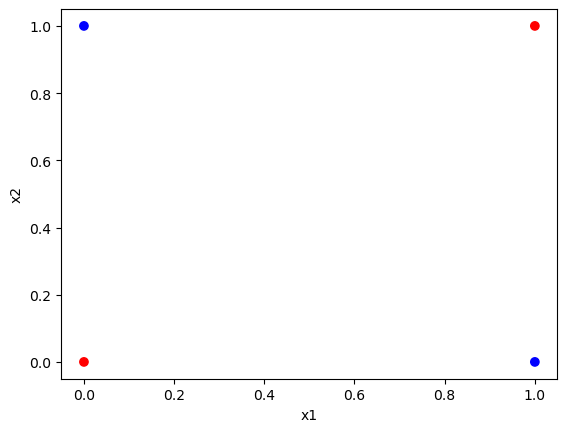

In [4]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

<u><font color="maroon"> **Q2.** How does a NN solve the XOR problem? [1 marks]</font></u>


We will implement back-propagation on a Feed Forward network to solve the XOR problem. The nework will have 2 inputs, 2 hidden neurons and one output neuron. The architecture is visualised as follows:

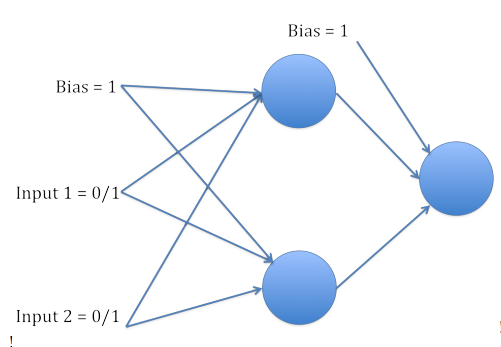

Using `LogisticRegression` and `sigmoid` from week 4 lab, implement the forward pass in the class below. Assume a single sample at a time (i.e. the shape of `x` is `(1, num_features`)). [2 marks]

Hint: Check `ModuleList` [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html).

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_neurons, num_outputs):
        super().__init__()
        self.hidden_layer = nn.ModuleList([LogisticRegression(num_inputs) for i in range(num_neurons)])
        self.output_layer = nn.ModuleList([LogisticRegression(num_neurons+1) for i in range(num_outputs)]) # +1 for the bias
        self.a_hidden = []
        self.z_hidden = []
        self.a_output = []
        self.z_output = []
        

    def forward(self, x: torch.tensor) -> torch.tensor:
        y_hidden = torch.ones(len(self.hidden_layer) + 1) # +1 for the bias
        ## your code here
        hidden_weights = list(model.hidden_layer.parameters())
        output_weights = list(model.output_layer.parameters())
        
        x = x.reshape(-1,1)
        
        a_hidden = []
        for i in hidden_weights:
            a_hidden.append(torch.mm(i,x))
        z_hidden = [sigmoid(i) for i in a_hidden]
        
        
        for i in range(len(z_hidden)):
            y_hidden[i] = z_hidden[i]
        
        z_hidden = y_hidden.reshape(-1,1)
        
        a_output = []
        for i in output_weights:
            a_output.append(torch.mm(i,z_hidden))
        z_output = [sigmoid(i) for i in a_output]
        
        self.a_hidden = a_hidden
        self.z_hidden = z_hidden
        self.a_output = a_output
        self.z_output = z_output
        
        return torch.tensor(z_output).reshape(-1,1)

    def backward_pass(self, x: torch.tensor, y: torch.tensor, lr: float) -> None:
        ### your code here
        sigmoid_deriv = lambda a: sigmoid(a) *(1 - sigmoid(a))
        output_weights = list(model.output_layer.parameters())
        hidden_weights = list(model.hidden_layer.parameters())
        
        z_hidden = self.z_hidden.reshape(1,-1)
        x = x.reshape(1,-1)
        
        z_output = torch.tensor(self.z_output)
        a_output = self.a_output
        a_output_sigmoid_deriv = torch.tensor([sigmoid_deriv(i) for i in a_output]).reshape(-1,1)
        y_diff = z_output - y
        delta_out = [a_output_sigmoid_deriv[i]*y_diff[i] for i in range(len(a_output_sigmoid_deriv))]
        
        a_hidden = self.a_output
        a_hidden_sigmoid_deriv = torch.tensor([sigmoid_deriv(i) for i in a_hidden])
        delta_hidden = []
        
        for j in range(len(a_hidden)):
            interim = 0
            for k in range(len(delta_out)):
                interim += output_weights[k][0][j]*delta_out[k]
            interim *= a_hidden_sigmoid_deriv[j]
            delta_hidden.append(interim)
        
        for i in range(len(delta_out)):
            output_weights[i] -= lr * delta_out[i]*z_hidden
        
        for i in range(len(delta_hidden)):
            hidden_weights[i] -= lr * delta_hidden[i] * x
        return [hidden_weights, output_weights]

In the `NeuralNetwork` class above, fill in the `backward_pass()` method. 

The implementation should support outputs of any size. To implement the backward pass, follow the steps below:



*   **Step 1:** For each output, $k$, calculate the partial derivative: $\delta_{k} = (y_{k}-t_{k}) \times g'(x_{k})$ \\
where $y_{k}$ is the response of the output neuron and $t_{k}$ is the desired output (target). The derivative of the sigmoid function $g'(x_{k})$ is defined as $g'(x_{k}) = g(x_{k}) × (1 - g(x_{k}))$ [1 marks]
*  **Step 2:** We now need to probagate this error to the hidden neurons. To accomplish this remember that: $$
 \delta_{j} = g^\prime(x_{j}) \sum_{k} w_{jk} \delta_{k}
$$  where $\delta_{j}$ is the error on the j-th hidden neuron,$x_{j}$ is the value of the hidden neuron (before it has been passed through the sigmoid function), $g^\prime$ is the derivative of the sigmoid function, $\delta_{k}$ is the error from the output neuron calculated in step 1, and $w_{jk}$ is the weight from the hidden neuron $j$ to the output neuron $k$. [1 marks]

* **Step 3:** We now need to update the output weights, i.e. the connections from the hidden neurons to the output neurons. This is accomplished using the formula: $$
 w_{jk} = w_{jk} - \eta \delta_{k} \alpha_{j}
$$ where $w_{jk}$ is the weight connecting the j-th hidden neuron to the k-th output neuron. $a_{j}$ is the activity of the j-th hidden neuron (after it has been transformed by the sigmoid function), $\delta_{k}$ is the error from the output neuron stored in output\_deltas and $\eta$ is the learning rate [1 mark]

* **Step 4:**  Finally we need to update the hidden weights, i.e. the connections from the hidden neurons to the inputs. Here, again we use this equation $$
 w_{ij} = w_{ij} - \eta \delta_{j} x_{i}
$$ where $w_{ij}$ is the weight connecting the i-th input to the j-th hidden neuron. $x_{i}$ is the i-th input, $\delta_{j}$ is the backpropagated error (i.e., hidden deltas) from the j-th hidden neuron and $\eta$ is the learning rate. [1 mark]



In [6]:
# test it works!!
x_test = torch.tensor([1.,-1., 1.0]) # last value is the bias
y_test = torch.tensor([1.,0.])
model = NeuralNetwork(num_inputs=3, num_neurons=3, num_outputs=2)
print(model(x_test))
print(model)
for name, param in model.named_parameters():
    print(name, param)

print('\nHidden layer weight matrix:')
print(torch.stack(list(model.hidden_layer.parameters())))

tensor([[0.6746],
        [0.7721]])
NeuralNetwork(
  (hidden_layer): ModuleList(
    (0): LogisticRegression()
    (1): LogisticRegression()
    (2): LogisticRegression()
  )
  (output_layer): ModuleList(
    (0): LogisticRegression()
    (1): LogisticRegression()
  )
)
hidden_layer.0.weight Parameter containing:
tensor([[0.4963, 0.7682, 0.0885]])
hidden_layer.1.weight Parameter containing:
tensor([[0.1320, 0.3074, 0.6341]])
hidden_layer.2.weight Parameter containing:
tensor([[0.4901, 0.8964, 0.4556]])
output_layer.0.weight Parameter containing:
tensor([[0.6323, 0.3489, 0.4017, 0.0223]])
output_layer.1.weight Parameter containing:
tensor([[0.1689, 0.2939, 0.5185, 0.6977]])

Hidden layer weight matrix:
tensor([[[0.4963, 0.7682, 0.0885]],

        [[0.1320, 0.3074, 0.6341]],

        [[0.4901, 0.8964, 0.4556]]])


In [7]:
#test it works
for i in range(1000):
    model.backward_pass(x_test, y_test, 0.1)
    

In [8]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    ### your code here
    y_true = y_true.reshape(-1,1)
    m = y_true.shape[0]
    return -(1/m)*(torch.mm(y_true.T,torch.log(y_pred))+torch.mm((1-y_true).T,torch.log(1-y_pred)))

Now modify the code below to train a model on the XOR problem. Make sure to use an appropriate lr and number of iterations. Use the BCE method from week 4 to visualize cost. [1 mark]

tensor([[0., 0., 1.],
        [0., 1., 1.],
        [1., 0., 1.],
        [1., 1., 1.]])
torch.Size([4, 3])


/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


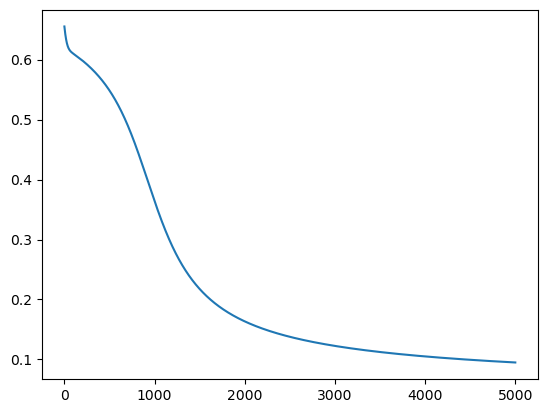

tensor([0., 1., 1., 0.]) tensor([0.1175, 0.9235, 0.9235, 0.9982])


In [9]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)
print(x)
print(x.shape)
y = torch.tensor([0., 1., 1., 0.])

lr = 1/10
iterations = 5000
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)

errors = list()
for ep in range(iterations):
    error = 0
    for i in range(x.shape[1]):
        # print(x[i])
        # raise 2
        y_pred = model(x[i])
        error += bce(y[i], y_pred)
        model.backward_pass(x[i], y[i], lr)
    errors.append(error/x.shape[1])
plt.plot(list(range(iterations)), errors)
plt.show()

y_pred = torch.zeros_like(y)
for i in range(x.shape[0]):
    y_pred[i] = model(x[i])
print(y, y_pred)

# 2. Iris Dataset
We will now use pytorch built-in methods to create an MLP classifier for the iris dataset.

In [10]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Split the data to train and test sets (make sure the same random seed is used as previously) and normalize using the method from week 4. We will use all attributes in this lab. [2 marks]

In [11]:
### your code here
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris.data,
    iris.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train).float()
x_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test).int()
y_test = y_test.reshape(-1, 1)

In [12]:
### your code here

x_train_mean = torch.mean(x_train,axis=0)
x_train_std = torch.std(x_train, axis=0)

def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
    return (x - mu)/sigma

def inv_norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
    return mu + sigma*x

x_train = norm_set(x_train, x_train_mean, x_train_std)
x_test = norm_set(x_test, x_train_mean, x_train_std)

In [13]:
x_train_copy = x_train.clone()
x_test_copy = x_test.clone()

In [14]:
class Net(nn.Module):
    def __init__(self, in_features,hidden_layers, out_features):
        super(Net, self).__init__()
        self.first = nn.Linear(in_features,hidden_layers)
        self.second = nn.Linear(hidden_layers, out_features)
        self.Sigmoid = nn.Sigmoid()
        self.Softmax = nn.Softmax()
        
    def forward(self,x):
        x1 = self.first(x)
        x2 = self.Sigmoid(x1)
        x3 = self.second(x2)
        # x4 = self.Softmax(x3)
        return x3

In [15]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
print(y_test.shape)

torch.Size([30, 3])


In [16]:
y_train = y_train.float()
y_test = y_test.float()

In [17]:
# model = Net(4,1,3)

Using pytorch built in methods (and using the training loop from week 4 as guideline for the train loop), build an MLP with one hidden layer. Train the network multiple times for the following number of hidden neurons `{1, 2, 4, 8, 16, 32}`. 

<u><font color="maroon"> **Q3.** Explain the performance of the different networks on the training and test sets. How does it compare to the logistic regression example? Make sure that the data you are refering to is clearly presented and appropriately labeled in the report. [8 marks]</font></u>

In [18]:
### your code here

def train(model, x, y, test_x, test_y, optimiser, alpha, hidden_layers):
    train_lst = list()
    test_lst = list()
    for i in range(1000):
        model.train()
        optimiser.zero_grad()
        pred = model(x)
        cost = F.cross_entropy(pred, y, reduction='mean')
        cost.backward()
        train_lst.append(cost.item())
        optimiser.step()
        model.eval()
        with torch.no_grad():
            test_pred = model(test_x)
            test_cost = F.cross_entropy(test_pred, test_y, reduction='mean')
            test_lst.append(test_cost)
    fig, axs = plt.subplots(2,figsize=(7,7))
    axs[0].set_title(f"Train - {hidden_layers} layer(s)")
    axs[0].plot(list(range(i+1)), train_lst)
    axs[1].set_title(f"Test - {hidden_layers} layer(s)")
    axs[1].plot(list(range(i+1)), test_lst)
    plt.show()
    print('Minimum train cost: {}'.format(min(train_lst)))
    print('Minimum test cost: {}'.format(min(test_lst)))


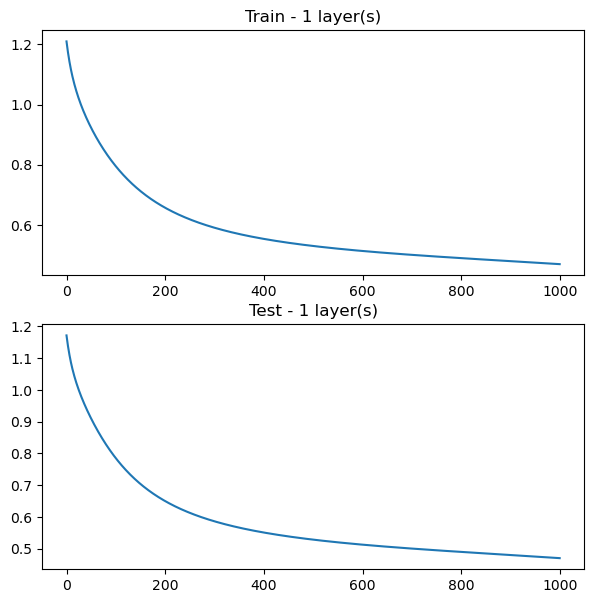

Minimum train cost: 0.4712011218070984
Minimum test cost: 0.47038835287094116


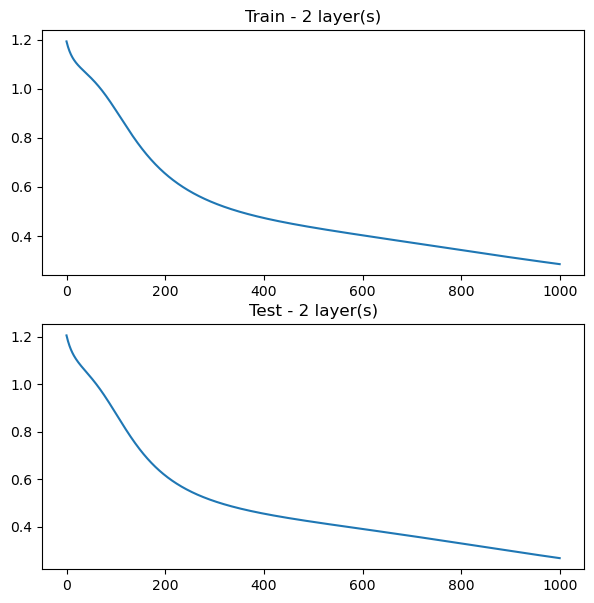

Minimum train cost: 0.28523001074790955
Minimum test cost: 0.26820313930511475


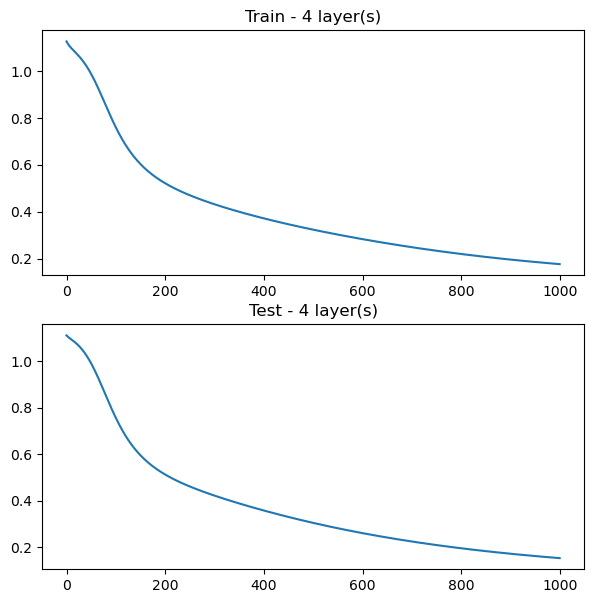

Minimum train cost: 0.1764027625322342
Minimum test cost: 0.1539151668548584


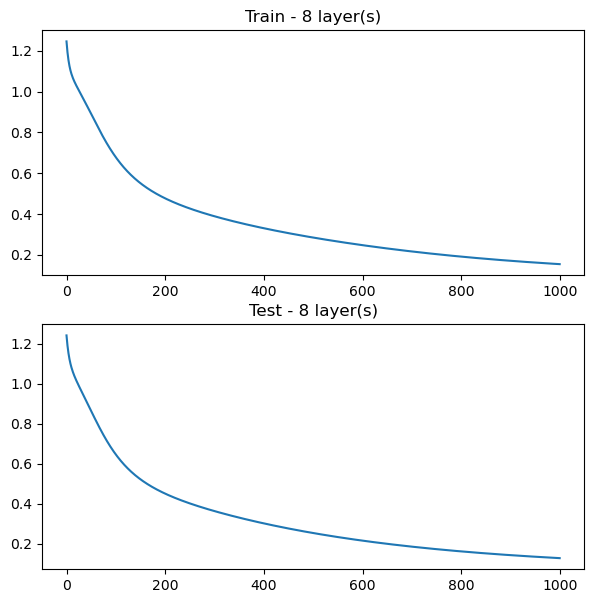

Minimum train cost: 0.15436869859695435
Minimum test cost: 0.12711955606937408


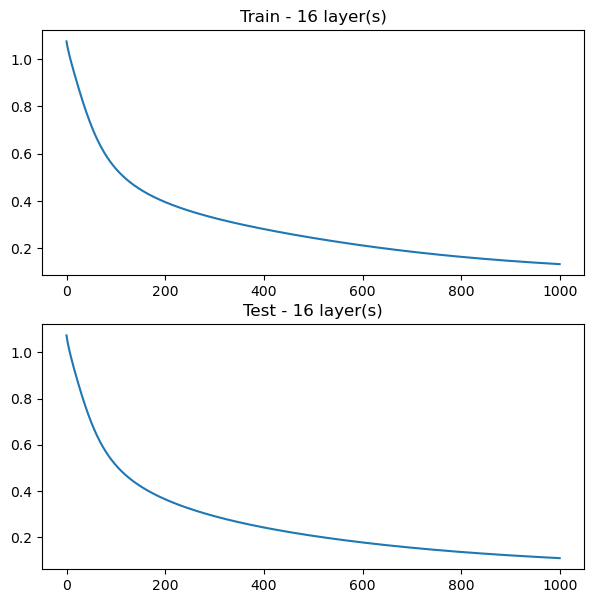

Minimum train cost: 0.1328376680612564
Minimum test cost: 0.11062882840633392


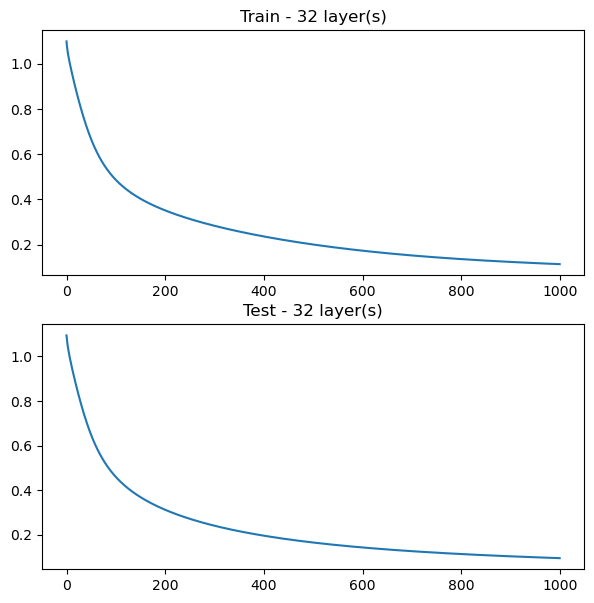

Minimum train cost: 0.11332007497549057
Minimum test cost: 0.09458502382040024


In [19]:
hidden_layers = [1,2,4,8,16,32]
alpha = 0.1
for layer in hidden_layers:
    
    x_train = x_train_copy.clone()
    x_test = x_test_copy.clone()
    model = Net(4,layer,3)
    optimiser = optim.SGD(model.parameters(), alpha)
    train(model, x_train,y_train,x_test,y_test,optimiser,alpha,layer)